Step 3 - Climate Analysis and Exploration

In [1]:
# Import dependencies
import datetime as dt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt

In [2]:
# Database setup
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Reflect an existing database into a new model
Base = automap_base()

In [4]:
# Reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# Save reference to the tables
Measurement = Base.classes.measurements
Stations = Base.classes.stations

In [6]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [7]:
# Get the table names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [8]:
# Measurements - list column names and types
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Stations - list of column names and types 
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# View data from Measurements
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', 0.0, 73.0)]

In [11]:
# View data from Stations
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

Climate Analysis: Precipitation

In [12]:
# Select prcp & date for the last 12 months 
# Reminder: Weather data last available for date 2017-08-23.

last_year_start = (dt.date(2017,8,23) - dt.timedelta(days=365)).isoformat()
query = f'SELECT date, prcp FROM measurements WHERE date > "{last_year_start}"'

# read query into dataframe
last_year_prec_df = pd.read_sql(query, engine)

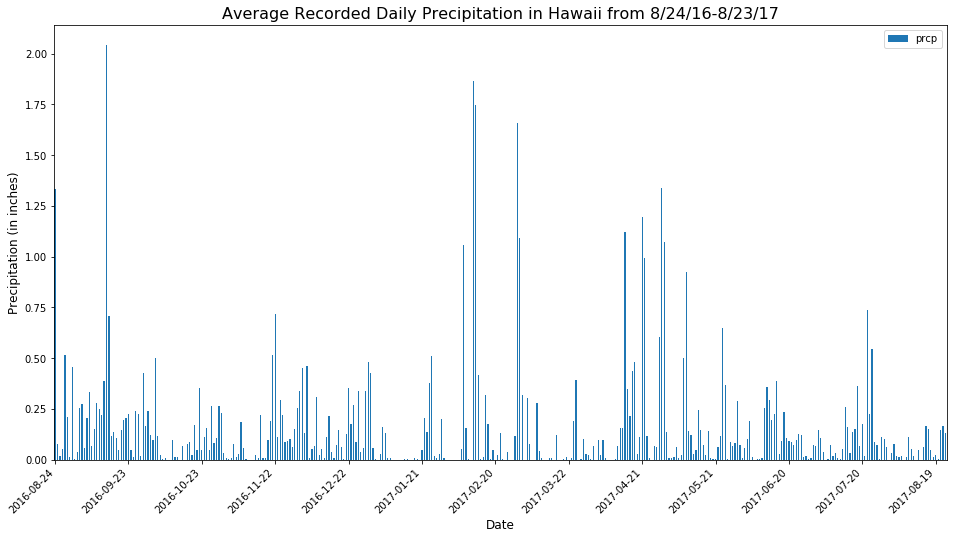

In [13]:
# Style 
plt.rcParams["figure.figsize"] = [16,8]

# Plot the dataframe
last_year_grouped_df = last_year_prec_df.groupby('date').mean().reset_index()
last_year_grouped_df.plot.bar(color='C0')
plt.title('Average Recorded Daily Precipitation in Hawaii from 8/24/16-8/23/17', 
          size=16)

# Set proper labels
plt.xticks([x*30 for x in np.arange(13)],
           [list(last_year_grouped_df['date'])[x*30] for x in np.arange(13)],
           rotation=45, horizontalalignment='right')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (in inches)", fontsize=12)
plt.show()

In [14]:
# Display summary statistics
summary_stats_df = (last_year_prec_df.describe().reset_index().
                    rename(columns={'index':'stat'}).copy())
summary_stats_df['precipitation'] = summary_stats_df['prcp'].round(2)
summary_stats_df

,stat,prcp,precipitation
0,count,2223.000000,2223.00
1,mean,0.159951,0.16
2,std,0.441220,0.44
3,min,0.000000,0.00
4,25%,0.000000,0.00
5,50%,0.010000,0.01
6,75%,0.110000,0.11
7,max,6.700000,6.70


In [15]:
summary_stats_df.drop(['prcp'], axis=1)

,stat,precipitation
0,count,2223.00
1,mean,0.16
2,std,0.44
3,min,0.00
4,25%,0.00
5,50%,0.01
6,75%,0.11
7,max,6.70


Climate Analysis : Station

In [16]:
# Query to calculate the total number of stations.
total_stations = pd.read_sql('SELECT COUNT(*) AS "Total Stations" FROM stations', 
                             engine)['Total Stations'][0]
print(f"There are {total_stations} weather stations in Hawaii.")

There are 9 weather stations in Hawaii.


In [17]:
# Query to find the most active stations.
# Display station with highest observation count and df of all stations.

query = 'SELECT measurements.station, stations.name, COUNT(measurements.tobs) AS "Count Observations" \
         FROM measurements JOIN stations ON stations.station = measurements.station \
         GROUP BY measurements.station ORDER BY COUNT(measurements.tobs) DESC'

station_obs_count_desc = pd.read_sql(query,engine)

highest_obs = f'{station_obs_count_desc["station"][0]} {station_obs_count_desc["name"][0]}'
print(f'The station with the highest observation count is {highest_obs}.')

station_obs_count_desc

The station with the highest observation count is USC00519281 WAIHEE 837.5, HI US.


,station,name,Count Observations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [18]:
# Query to retrieve the last 12 months of temperature observation data (tobs)
temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()
temps

[('USC00519397', '2016-08-23', 81.0),
 ('USC00513117', '2016-08-23', 76.0),
 ('USC00514830', '2016-08-23', 80.0),
 ('USC00517948', '2016-08-23', 80.0),
 ('USC00519523', '2016-08-23', 80.0),
 ('USC00519281', '2016-08-23', 77.0),
 ('USC00516128', '2016-08-23', 74.0),
 ('USC00519397', '2016-08-24', 79.0),
 ('USC00513117', '2016-08-24', 76.0),
 ('USC00514830', '2016-08-24', 80.0),
 ('USC00517948', '2016-08-24', 78.0),
 ('USC00519523', '2016-08-24', 79.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00516128', '2016-08-24', 74.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00513117', '2016-08-25', 77.0),
 ('USC00514830', '2016-08-25', 81.0),
 ('USC00517948', '2016-08-25', 81.0),
 ('USC00519523', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00516128', '2016-08-25', 77.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00513117', '2016-08-26', 78.0),
 ('USC00514830', '2016-08-26', 81.0),
 ('USC00517948', '2016-08-26', 81.0),
 ('USC00519523', '2016-08-26', 84.0),
 ('USC005192

In [19]:
# Filter by the station with the highest number of observations.
highest_obs = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date > '2016-08-22').\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
highest_obs

[('USC00519397', 81.0),
 ('USC00519281', 79.0),
 ('USC00516128', 76.0),
 ('USC00513117', 77.0),
 ('USC00519523', 82.0),
 ('USC00514830', 82.0),
 ('USC00517948', 81.0)]

In [20]:
df = pd.DataFrame(temps, columns=['Station', 'date', 'temp'])
df.set_index('Station', inplace=True)
df.head()

,date,temp
Station,,
USC00519397,2016-08-23,81.0
USC00513117,2016-08-23,76.0
USC00514830,2016-08-23,80.0
USC00517948,2016-08-23,80.0
USC00519523,2016-08-23,80.0


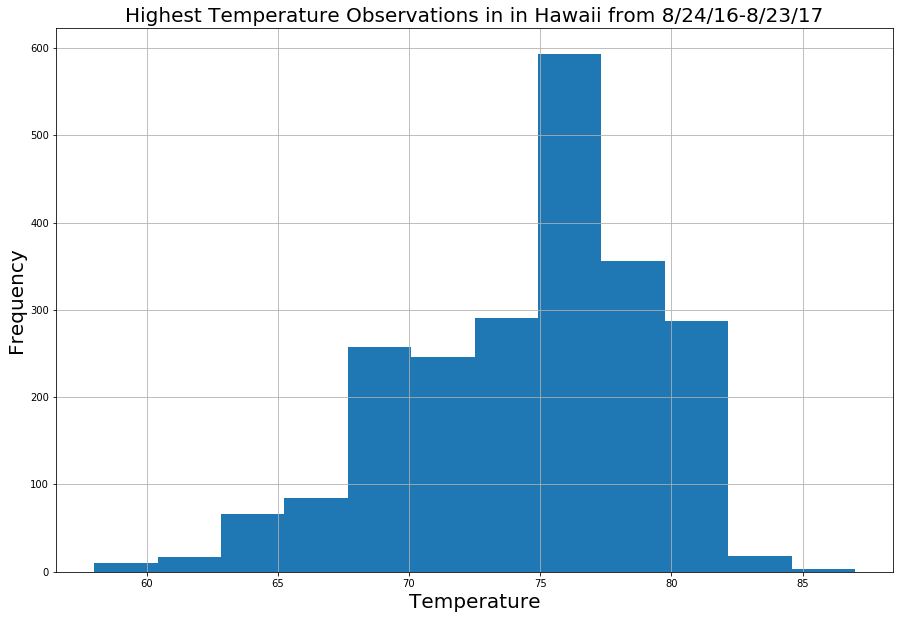

In [21]:
# Plot the results as a histogram with bins = 12
hist_plot = df['temp'].hist(bins=12, figsize=(15,10))
hist_plot.set_title('Highest Temperature Observations in in Hawaii from 8/24/16-8/23/17', fontsize=20)
hist_plot.set_ylabel('Frequency', fontsize=20)
hist_plot.set_xlabel('Temperature', fontsize=20)
plt.show()

Climate Analysis : Temperature

In [22]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d
# Return the minimum, average, and maximum temperatures for that range of dates.
# Selected trip date = 2018-08-01 to 2018-08-05 .. will use data from last 2017.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-08-01', '2017-08-05'))

[(72.0, 78.42105263157895, 83.0)]


In [23]:
# Measurements - list column names and types
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [24]:
temperatures = (calc_temps('2017-08-01', '2018-08-05'))
labels = ['lowest_temp', 'avg_temp', 'highest_temp']
df_calc = pd.DataFrame.from_records(temperatures, columns=labels)
df_calc

,lowest_temp,avg_temp,highest_temp
0,70.0,78.824176,85.0


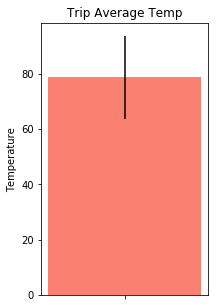

In [25]:
    plt.figure(figsize=(3,5))
    plt.bar(1, df_calc.avg_temp, yerr= df_calc.highest_temp - df_calc.lowest_temp, tick_label='', color='salmon')
    plt.ylabel("Temperature")
    plt.title("Trip Average Temp")
    plt.show()

Step 4 - Climate App

In [26]:
# Flask Setup
app = Flask(__name__)

In [27]:
@app.route("/")
def welcome1():
    """Listing of the available API routes"""
    return(
        f"Available Routes: <br/>"
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [28]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Query for the dates and temps for the last year"""
    
    # Query the database for dates and tobs
    prcp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-01-01').all()
    
    # Create dictionary from row data and append to the list 'all_prcp'
    all_prcp = []
    for prcp in prcp_results:
        prcp_dict = {}
        prcp_dict["Date"] = Measurement.date
        prcp_dict["TOBS"] = Measurement.tobs
        all_prcp.append(prcp_dict)
    return jsonify(all_prcp)

In [29]:
@app.route("/api/v1.0/stations")
def stations():
    """Returns a list of stations from the dataset in JSON format"""
    
    station_results = session.query(Station.station).all()
    
    # Convert the list of tuples into a normal list:
    all_stations = list(np.ravel(station_results))
    
    return jsonify(all_stations)

In [30]:
@app.route("/api/v1.0/tobs")
def tobs():
    """Returns a list of temperature observations from the last year in JSON format """
    
    #Query database for tobs for last year
    tobs_results = session.query(Measurement.tobs).filter(Measurement.date > '2017-01-01').all()
    
    # Convert the list of tuples into normal list:
    all_tobs = list(np.ravel(tobs_results))
    
    return jsonify(all_tobs)

In [31]:
if __name__ == '__main__':
    app.run(debug=True)

 * Restarting with stat


SystemExit: 1

C:\Users\Vilma\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
